In [1]:
import sys 

import sklearn
import numpy as np 
import os
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.utils import io

import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict,GridSearchCV
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,r2_score,mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# Web scarpping
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException,TimeoutException

### Getting the data
To get the data we are going to scrape it from cars and bids. This is an online auction site founded by Doug DeMuro, allowing individuals to purchase and sell vehicles in online auctions.

#### Links

First we need to get the links of the car. We can go the the past auctions page, and pass the page number in the url. Then loop in all the listing using the XPapth and store their link in a list.

![img](img/past-auctions.png)

In [2]:
def get_hrefs(driver,i):
    driver.get(f"https://carsandbids.com/past-auctions/?page={i}")
    hrefs = []
    WebDriverWait(driver,20).until(EC.presence_of_element_located((By.CLASS_NAME, "auction-item ")))

    for i in range(1,51):
        try:
            a= driver.find_element(By.XPATH ,F"/html/body/div/div[2]/div[2]/div/ul[1]/li[{i}]/div[2]/div/a")
        except NoSuchElementException:
            return hrefs
        hrefs.append(a.get_attribute("href"))
    
    return hrefs

#### car data 

Next we will visit each link and get the data from it.
There are many different items we want from the page. But I thought this will be the most relevant.
![](img/car_data.jpg)

1. Make of the car
1. Model of the car
1. milage on the car
1. location of the car
1. engine size and type
1. drive train of the car
1. transsmision type and number of gears
1. body style of the car
1. color

![](img/price_data.jpg)

10. year of the car
10. number of photos
10. price and bid status
10. number of bids
10. number of comments

![](img/highlights-flaws.jpg)

From here we can't actually use the data from the text, but we will take the number of higlights and flaws as a feuture

In [3]:
def add_to_df(driver,link,df):
    driver.get(link.split("-")[0])

    WebDriverWait(driver,20).until(EC.presence_of_element_located((By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[1]/dd[1]/a')))
    sold = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[3]/div[1]/div/div/ul/li[1]/span[2]')
    name = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[1]/div/div[1]/h1')
    make = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[1]/dd[1]/a')
    try:
        model = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[1]/dd[2]/a')
    except NoSuchElementException:
        return
    mileage = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[1]/dd[3]')
    title_status = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[1]/dd[5]')
    location = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[1]/dd[6]/a')
    engine = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[2]/dd[1]')
    drivetrain = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[2]/dd[2]')
    transmission = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[2]/dd[3]')
    body_style = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[2]/dd[4]')
    color = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[2]/dl[2]/dd[5]')
    state_of_acution = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[3]/div[1]/div/div/ul').text
    if "Cancelled" in state_of_acution:
        return
    price = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[6]/div/div/span')

    higlights_list = driver.find_elements(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[3]/div[2]/div/ul/li')
    flaws_list = driver.find_elements(By.XPATH, '/html/body/div/div[2]/div[5]/div[1]/div[3]/div[5]/div/ul/li')
    num_of_bids = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[3]/div[1]/div/div/ul/li[3]/span[2]')
    num_of_comments = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[3]/div[1]/div/div/ul/li[4]/span[2]')
    num_of_images = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[2]/div/div[1]/div/div[2]/div[2]/div[4]/div')
    if engine.text.find("Electric") != -1:
        return
    d_year = name.text.split(" ")[0]
    d_title = title_status.text.split(" ")[0]
    d_loc = location.text.split(",")[1].split(" ")[1]
    d_engine_size = engine.text.split(" ")[0]
    d_engine_type = engine.text.split(" ")[-1]
    d_trans_type = transmission.text.split(" ")[0]

    if len(transmission.text.split(" ")) != 1:
        d_trans_speed = transmission.text[transmission.text.find("(")+1:transmission.text.find(")")]
    else:
        d_trans_speed = None

    num_of_images = num_of_images.text[num_of_images.text.find("(")+1:num_of_images.text.find(")")]

    row = {
        'year' : d_year,
        'make' : make.text,
        'model': model.text,
        'mileage': mileage.text,
        'state of origin': d_loc,
        'engine size': d_engine_size,
        'engine type': d_engine_type,
        'drivetrain': drivetrain.text,
        'transmmision type': d_trans_type,
        'number of gears': d_trans_speed,
        'body_style': body_style.text,
        'color': color.text,
        'numberg of higlights': len(higlights_list),
        'number of flaws': len(flaws_list),
        'num of bids': num_of_bids.text,
        'num of comments': num_of_comments.text,
        'num of images': num_of_images,
        'sold': 1 if "sold" in sold.text.lower() else 0,
        'price': price.text,
    }

    df.append(row)

In [66]:
def scarpe():
    driver = webdriver.Firefox(executable_path="./geckodriver")

    data = []
    # still need to manually update the number of pages
    last = ""
    for i in range(1,2):
        links = get_hrefs(driver,i)

        for link in links:
            try:
                add_to_df(driver,link,data)
            except NoSuchElementException as e:
                print(f"{link} - {e}")
            except TimeoutException:
                print(link, " not found")

        df = pd.DataFrame(data)
        last = f"my_data_{i}.csv"
        df.to_csv(last)
    os.rename(last,"my_data.csv")

#only start to scape is there is not data
if not os.path.isfile("my_data.csv"):
    scarpe()

## About the data
From the web scarping process, I took this featuers:
1. year - year of car production
1. make - the maker of the car
1. model - the model of the car
1. mileage - the mileage (as shown on the odometer)
1. state of origin - where the actuoin was placed
1. engine size - the engine size in L/cc
1. engine type - the engine structure (V8/I4/Flat-12 ...)
1. drivetrain - type of drive train (RWD/FWD/AWD)
1. transmmision type - manuel or automatic transmmision
1. number of gears -nuber of gears in the transmision(cvt = -1)
1. body_style - the body style of the car(saden/ coupe /SUV...)
1. color - the color of the car
1. numberg of higlights - the nuber of highloghts that the owner wrote in the post
1. number of flaws - the nuber of highloghts that the owner wrote in the post
1. num of bids - the number of bids people gave
1. num of comments - the number of comments on the auction post
1. num of images - how many images the owner gave
1. sold - if the acution was succsesfull or not(reserve met)
1. price - the price of the last bit(whether it was sold or not)

## Cleaning the data

In [5]:
df : pd.DataFrame = pd.read_csv('my_data.csv')

In [6]:
df.head()

,Unnamed: 0,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,num of bids,num of comments,num of images,sold,price
0,0,2008,Porsche,911,"18,400",WA,3.6L,Flat-6,Rear-wheel drive,Manual,6-Speed,Coupe,Black,6,8,34,100,101,0,"$160,000"
1,1,1992,Buick,Roadmaster,"15,100",TX,5.7L,V8,Rear-wheel drive,Automatic,4-Speed,Sedan,Dark Maple Red,5,0,23,83,90,1,"$9,300"
2,2,2001,BMW,M3,"67,800 Miles Shown",NY,3.2L,I6,Rear-wheel drive,Manual,6-Speed,Coupe,Titanium Silver Metallic,5,10,32,115,82,1,"$29,000"
3,3,2005,Mercedes-Benz,E55 AMG,"112,800",KY,5.4L,V8,Rear-wheel drive,Automatic,5-Speed,Sedan,Black Opal Metallic,5,7,8,36,121,0,"$11,100"
4,4,2002,BMW,X5,"125,800",GA,4.6L,V8,4WD/AWD,Automatic,5-Speed,SUV/Crossover,Black Sapphire Metallic,5,15,29,26,146,1,"$9,600"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5765 entries, 0 to 5764
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            5765 non-null   int64 
 1   year                  5765 non-null   object
 2   make                  5765 non-null   object
 3   model                 5765 non-null   object
 4   mileage               5765 non-null   object
 5   state of origin       5765 non-null   object
 6   engine size           5765 non-null   object
 7   engine type           5765 non-null   object
 8   drivetrain            5765 non-null   object
 9   transmmision type     5765 non-null   object
 10  number of gears       5728 non-null   object
 11  body_style            5765 non-null   object
 12  color                 5765 non-null   object
 13  numberg of higlights  5765 non-null   int64 
 14  number of flaws       5765 non-null   int64 
 15  num of bids           5765 non-null   

Let's check for any null data

In [8]:
df.isnull().sum()

Unnamed: 0               0
year                     0
make                     0
model                    0
mileage                  0
state of origin          0
engine size              0
engine type              0
drivetrain               0
transmmision type        0
number of gears         37
body_style               0
color                    0
numberg of higlights     0
number of flaws          0
num of bids              0
num of comments          0
num of images            0
sold                     0
price                    0
dtype: int64

In [9]:
df[df.isnull().any(axis=1)]

,Unnamed: 0,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,num of bids,num of comments,num of images,sold,price
1050,1050,2016,Tesla,Model S,"84,300",IL,Dual,90D,4WD/AWD,Automatic,NaN,Sedan,Midnight Silver Metallic,7,4,33,41,74,1,"$50,000"
2010,2010,2018,Tesla,Model 3,"76,900",CA,Single,Motor,Rear-wheel drive,Automatic,NaN,Sedan,Black,4,2,22,32,125,1,"$44,069"
2029,2029,2016,Tesla,Model X,"27,700",CA,Dual,Motors,4WD/AWD,Automatic,NaN,SUV/Crossover,Obsidian Black Metallic,7,1,19,51,72,1,"$64,500"
2057,2057,2020,Tesla,Model Y,"13,500",FL,Dual,Motors,4WD/AWD,Automatic,NaN,SUV/Crossover,Black,4,2,12,21,65,1,"$56,000"
2130,2130,2016,Tesla,Model X,"9,900",CA,Dual,Motors,4WD/AWD,Automatic,NaN,SUV/Crossover,Titanium Metallic,4,0,13,35,61,1,"$68,656"
2228,2228,2016,Tesla,Model X,"48,900",CA,Dual,Motors,4WD/AWD,Automatic,NaN,SUV/Crossover,Deep Blue Metallic,5,2,27,42,51,0,"$61,500"
2274,2274,2013,Tesla,Model S,"3,780",PA,Single,Motor,Rear-wheel drive,Automatic,NaN,Sedan,White,5,0,21,145,69,0,"$29,250"
2312,2312,2020,Tesla,Model Y,"7,500",CA,Dual,Motors,4WD/AWD,Automatic,NaN,SUV/Crossover,White,5,3,14,67,76,0,"$51,000"
2323,2323,2019,Tesla,Model X,"23,100",TX,Dual,Motors,4WD/AWD,Automatic,NaN,SUV/Crossover,Red,5,2,19,56,85,0,"$70,500"
2473,2473,2021,Tesla,Model S,800,PA,Triple,Motors,4WD/AWD,Automatic,NaN,Sedan,Solid Black,5,0,15,168,134,0,"$132,000"


We can see that this are the electirc cars, that have no gears. So let's give them 1 gear

In [10]:
df.loc[df.isnull().any(axis=1),'number of gears'] = 1

We are only intrested in the sold cars. Becuase of we have a car that didn't sell that means that bid was no in the range of the price pf the car

In [11]:
df = df.drop(df.loc[df['sold'] == 0].index)
df = df.drop('sold',axis=1)

in one page there was no year of prduction, insted it was "Consumer" somthing.. so I just deleted this row,  + the Unamed:0 colum the was the resualt of combing of all the dataframes from the scrapper.

In [12]:
df = df.drop("Unnamed: 0",axis=1)
df = df.drop(df.loc[df['year'] == '"Consumer'].index)

### fixing the numerical columns

Some columns are in numbers, but becuase there was a charecter in them ('$',',','L') so I needed to prase the change them to numerical data(int/float)

In the price column all we need to do is to remove the '$' symbol infront and remove the ','

In [13]:
df["price"] = df["price"].apply(lambda x: x[1:])
df["price"] = df["price"].apply(lambda x: x.replace(",",""))

In the mileage column, we remove the ',' smbol as well as the '~' symbol that were on one car.
moreover their were some comments on the mileage column, that said xxxx miles on the odometer, I also got rid of them.

In [14]:
def get_miles_from_str(x):
    if isinstance(x,int):
        return x
    x = x.replace(",","")
    x = x.split(" ")[0]
    x = x.replace("~","")
    if x[0].isdigit():
        return x
    return 0

df["mileage"] = df["mileage"].apply(lambda x: get_miles_from_str(x))

In the engine colum their were more problems. Some were electric, some in Liters, some in cc and some were completlly missing.
I fixed the missing manually by checking simmilar cars. 
all of the Electric cars were given 0 engine size, and all the other car's engine size were represented in cc

In [15]:
df["engine size"] = df["engine size"].replace(['Single','Dual','Triple','AC','EV'],0)
def convert(x : str):
    if isinstance(x,int):
        return x
    elif "cc" in x:
        x = x.replace("cc","")
        return int(x)
    elif "Liter" in x:
        x = x.replace("-Liter","")
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"
        return int(x)
    elif "L" in x:
        x = x.replace("L","")
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"
        return int(x)
    elif "." in x:
        x = x.replace(".","")
        x = x.replace("-liter","")
        for i in range(0,4 -len(x)):
            x = x + "0"
        return int(x)
    else:
        return x
    

df["engine size"] = df["engine size"].apply(convert)

there were cars that wrote the enine entry not like everyone else,becuse it just 5 cars, lets drop them.

In [16]:
to_fix_df = []
def convert(x : int):
    try:
        y = int(x)
        if isinstance(y,int):
            return x
    except ValueError:    
        to_fix_df.append(df.loc[df['engine size'] == x])

df["engine size"].apply(convert);
tf = pd.DataFrame()
for f in to_fix_df:
    tf = pd.concat([tf,f])

df = df.drop(tf.index)

In [17]:
df['engine type'].unique()

array(['V8', 'I6', 'V6', 'I4', 'Flat-4', 'Flat-6', 'V10', 'I5', 'V12',
       'Rotary', 'turbodiesel', 'I3', '6', 'V2', 'H6', '12-Cylinder', '4',
       'W12', '90D', 'Inline-4', 'W8', 'VR6', '3.0L', 'Diesel', 'Motor',
       'Motors', 'H4', 'I-4', 'Turbodiesel', 'Turbo', '75', 'I-6', 'P90D',
       'I-3', '100D', 'Flat-2', '75D', 'generator', '85', 'P85', 'EV',
       'i4', 'motor', 'Hybrid', 'V-8', 'Flat-Six'], dtype=object)

again, not all post were equal. So I had to fix it manually.

I also combined all the same engines, that had different names like "I4", "Inline-4","i-4" etc...

In [18]:
df.loc[df["engine type"] == "Canada","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Supercharged","engine type"] = "V6"
df.loc[df["engine type"] == "Diesel","engine type"] = "I4"
df.loc[df["engine type"] == "3.0L","engine type"] = "I6"
df.loc[df["engine type"] == "turbodiesel","engine type"] = "I6"
df.loc[df["engine type"] == "I-6","engine type"] = "I6"
df.loc[df["engine type"] == "Turbodiesel","engine type"] = "V6"
df.loc[df["engine type"] == "VR6","engine type"] = "V6"
df.loc[df["engine type"] == "Turbo","engine type"] = "I4"
df.loc[df["engine type"] == "4","engine type"] = "Flat-4"
df.loc[df["engine type"] == "6","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Inline-4","engine type"] = "I4"
df.loc[df["engine type"] == "i4","engine type"] = "I4"
df.loc[df["engine type"] == "I-4","engine type"] = "I4"
df.loc[df["engine type"] == "I-3","engine type"] = "I3"
df.loc[df["engine type"] == "Hybrid","engine type"] = "V6"
df.loc[df["engine type"] == "H6","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Flat-Six","engine type"] = "Flat-6"
df.loc[df["engine type"] == "H4","engine type"] = "Flat-4"
df.loc[df["engine size"] == 0,"engine type"] = "electric"


I changed the number of gears, so that I have this column in integers. and again' needed to fix some values manually

In [19]:
df.loc[df["number of gears"] == "3.6L V6","number of gears"] = "6-speed"
def simplefy_gears(x:str):
    if not isinstance(x,str):
        return 0
    if x == "CVT":
        return -1
    x = x.split("-")[0]
    return x

df["number of gears"] = df["number of gears"].apply(simplefy_gears)

There were to many collor. So I grouped all of them together

In [20]:
def simplefy_color(x : str):
    if "white" in x.lower():
        x = "white"
    elif "black" in x.lower():
        x = "black"
    elif "red" in x.lower():
        x = "red"
    elif "blue" in x.lower():
        x = "blue"
    elif "yellow" in x.lower():
        x = "yellow"
    elif "grey" in x.lower():
        x = "grey"
    elif "green" in x.lower():
        x = "green"
    elif "silver" in x.lower():
        x = "silver"
    elif "orange" in x.lower():
        x = "orange"
    elif "metallic" in x.lower():
        x = "metallic"
    elif "pearl" in x.lower():
        x = "pearl"
    elif "gold" in x.lower():
        x = "gold"
    elif "beige" in x.lower():
        x = "beige"
    else:
        x = "special"

    return x

df["color"] = df["color"].apply(simplefy_color)

Now let's make everything numerical

In [21]:
df["price"] = df['price'].astype(str).astype(int)
df["mileage"] = df['mileage'].astype(str).astype(int)
df["year"] = df['year'].astype(str).astype(int)
df["engine size"] = df['engine size'].astype(str).astype(int)
df["number of gears"] = df['number of gears'].astype(str).astype(int)

In [22]:
df.head()

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,num of bids,num of comments,num of images,price
1,1992,Buick,Roadmaster,15100,TX,5700,V8,Rear-wheel drive,Automatic,4,Sedan,red,5,0,23,83,90,9300
2,2001,BMW,M3,67800,NY,3200,I6,Rear-wheel drive,Manual,6,Coupe,silver,5,10,32,115,82,29000
4,2002,BMW,X5,125800,GA,4600,V8,4WD/AWD,Automatic,5,SUV/Crossover,black,5,15,29,26,146,9600
6,2007,BMW,Alpina B7,108500,OH,4400,V8,Rear-wheel drive,Automatic,6,Sedan,black,4,0,21,54,77,16000
8,1995,BMW,540i,94700,CA,4000,V8,Rear-wheel drive,Manual,6,Sedan,black,6,12,30,26,152,14000


I combined this cloumn to describe how detailed was the post. It made sense that a more detailed post, were bidded higher(even thought it was a wrong assamption)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4959 entries, 1 to 5764
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   year                  4959 non-null   int64 
 1   make                  4959 non-null   object
 2   model                 4959 non-null   object
 3   mileage               4959 non-null   int64 
 4   state of origin       4959 non-null   object
 5   engine size           4959 non-null   int64 
 6   engine type           4959 non-null   object
 7   drivetrain            4959 non-null   object
 8   transmmision type     4959 non-null   object
 9   number of gears       4959 non-null   int64 
 10  body_style            4959 non-null   object
 11  color                 4959 non-null   object
 12  numberg of higlights  4959 non-null   int64 
 13  number of flaws       4959 non-null   int64 
 14  num of bids           4959 non-null   int64 
 15  num of comments       4959 non-null   

In [24]:
df.describe(include='all')

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,num of bids,num of comments,num of images,price
count,4959.000000,4959,4959,4959.000000,4959,4959.000000,4959,4959,4959,4959.000000,4959,4959,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000
unique,NaN,86,747,NaN,63,NaN,18,3,2,NaN,8,14,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,BMW,911,NaN,CA,NaN,V8,Rear-wheel drive,Automatic,NaN,Sedan,black,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,950,133,NaN,983,NaN,1803,2662,2827,NaN,1283,1024,NaN,NaN,NaN,NaN,NaN,NaN
mean,2003.689454,NaN,NaN,82828.562210,NaN,3653.165154,NaN,NaN,NaN,5.487598,NaN,NaN,5.324662,5.666263,28.708409,68.373059,116.102642,22193.185521
std,9.239537,NaN,NaN,54940.257435,NaN,1450.959322,NaN,NaN,NaN,1.276513,NaN,NaN,0.888873,3.945184,13.227280,51.589174,45.765879,23224.165271
min,1981.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,-1.000000,NaN,NaN,3.000000,0.000000,1.000000,2.000000,37.000000,1800.000000
25%,1997.000000,NaN,NaN,41600.000000,NaN,2500.000000,NaN,NaN,NaN,5.000000,NaN,NaN,5.000000,3.000000,19.000000,36.000000,83.000000,9000.000000
50%,2004.000000,NaN,NaN,74500.000000,NaN,3400.000000,NaN,NaN,NaN,5.000000,NaN,NaN,5.000000,5.000000,27.000000,55.000000,106.000000,15152.000000
75%,2011.000000,NaN,NaN,113600.000000,NaN,4700.000000,NaN,NaN,NaN,6.000000,NaN,NaN,6.000000,8.000000,37.000000,85.000000,139.000000,25870.000000


### some insights
 
- most of the cars are realletivly old (2010 and under) while the mean year is 2003
- the most sold brand is the BMW
- the most sold model is the 911(Porchse) which is not quite unsuall as porsche does not have as many model as BMW
- the avarage car in the US does ~82K miles.
- the US being US loves big engine and it shows in the avarage engine size(3.6L) althought it is not quite right becuase we gave electric engines size of 0. but They dont acutally have a size
- the most sold combo is a V8 engine, RWD with automatic transmision.
- the most sold color is black
- and finnaly the avarage car price is ~22K where most of them go under 25K

## Analyzing the data

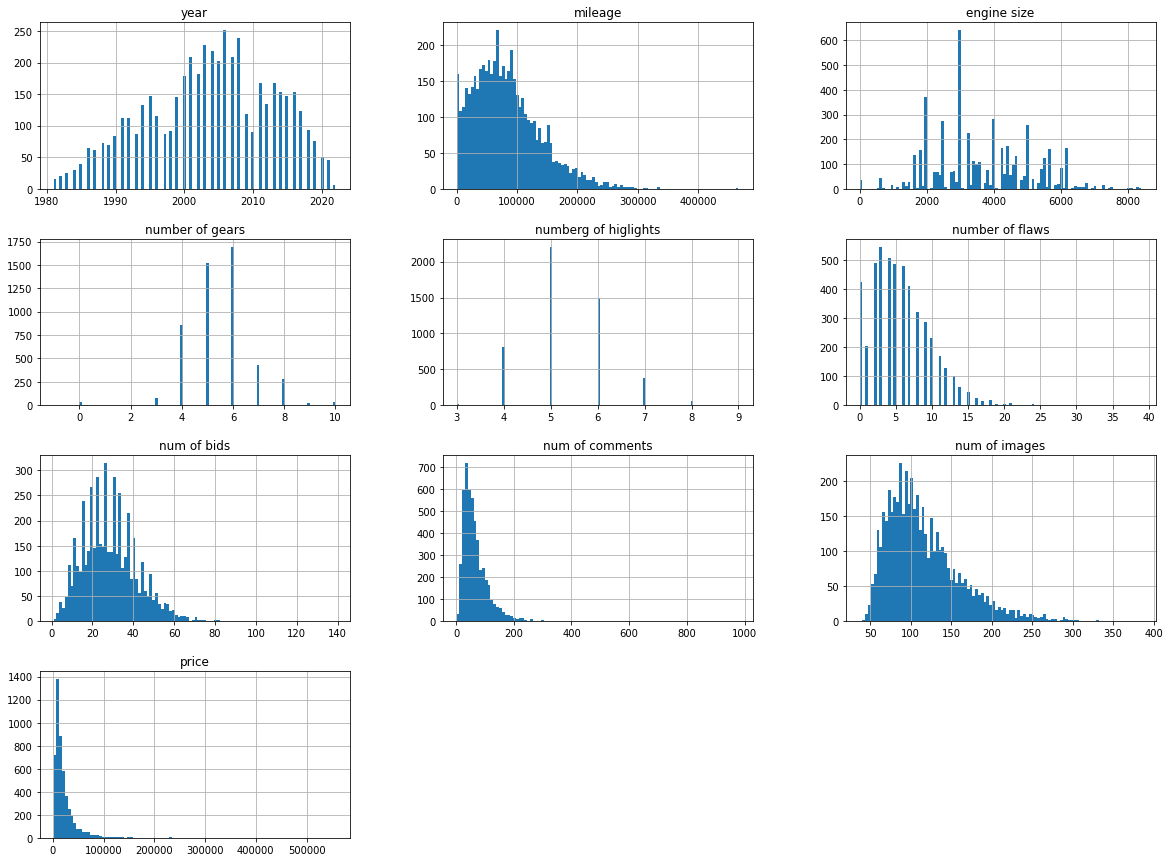

In [25]:
fig_size=(20,15)
df.hist(bins=100, figsize=(20,15));

We can see that the data is not balanced as most of the cars are are under $50K

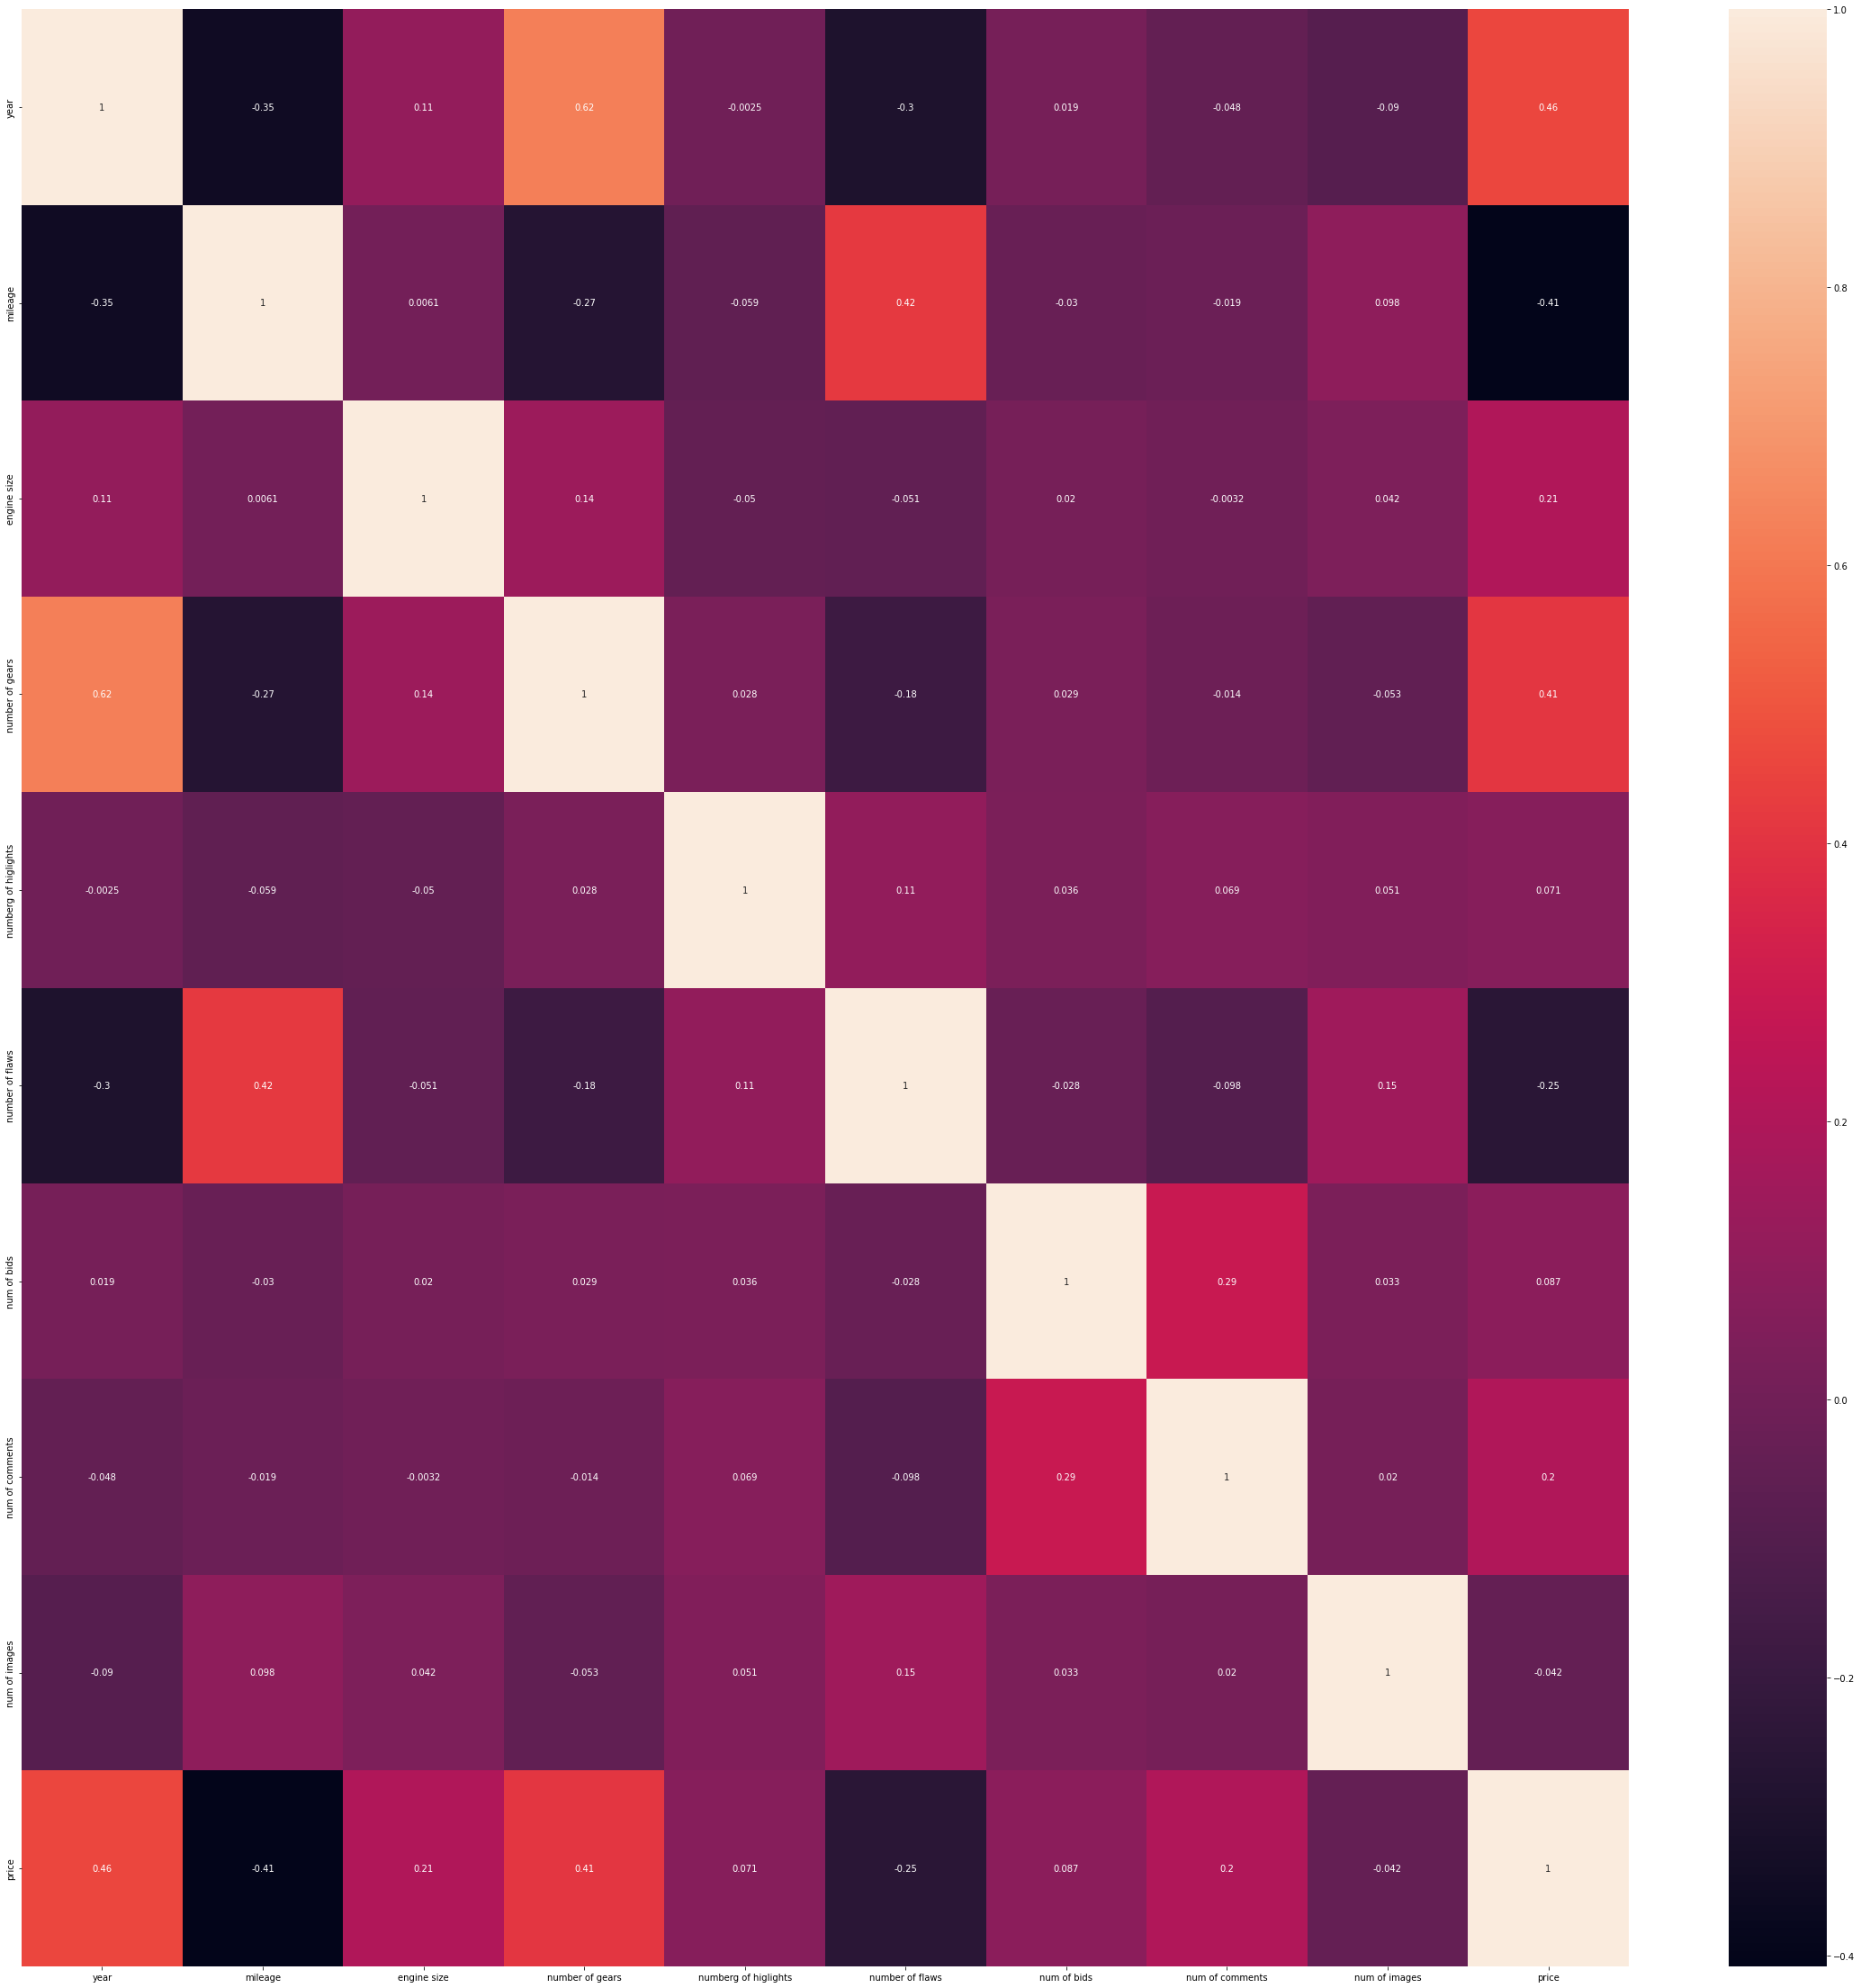

In [26]:
corr_mat= df.corr()
f, ax = plt.subplots(figsize=(40,40))
sns.heatmap(corr_mat,annot=True);

To understand oue data a little bit more, I wanted to see how much different The car's price form their avarage selling price.Becuse it uses the price column, I wont be using it in the model training, but it's a good way to see that no model can hit 100%, even humans can't

In [27]:
df.groupby(['make','model'])['price'].mean()
means = df.groupby(['make','model','year']).transform('mean')
df['price diff'] = df['price'] - means['price']

<AxesSubplot:>

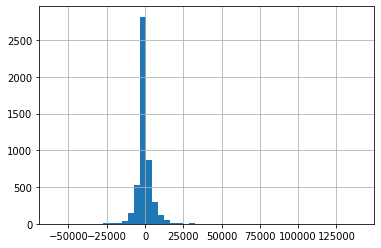

In [28]:
df['price diff'].hist(bins=50)

You can see that their are cars thet sell by almost 100k more!

In [29]:
df.loc[df['price diff'].abs() > 50000]

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,num of bids,num of comments,num of images,price,price diff
286,2016,Mercedes-Benz,G63 AMG,6600,FL,5500,V8,4WD/AWD,Automatic,7,SUV/Crossover,black,6,3,65,112,132,247500,112500.000000
419,2020,Ford,Mustang,1300,ME,5200,V8,Rear-wheel drive,Manual,6,Coupe,white,6,1,42,59,217,136000,53083.333333
447,2005,Ferrari,F430,24600,CA,4300,V8,Rear-wheel drive,Manual,6,Convertible,special,6,6,45,113,95,220000,73666.666667
955,2016,Mercedes-Benz,G63 AMG,64500,FL,5500,V8,4WD/AWD,Automatic,7,SUV/Crossover,black,5,7,23,46,73,78500,-56500.000000
1104,2008,Porsche,911,16500,QC,3600,Flat-6,Rear-wheel drive,Manual,6,Coupe,green,7,4,29,235,161,231500,139747.600000
2574,2016,Mercedes-Benz,G63 AMG,65200,OR,5500,V8,4WD/AWD,Automatic,7,SUV/Crossover,metallic,5,5,19,43,138,79000,-56000.000000
2955,2017,Porsche,911,9800,CA,3800,Flat-6,4WD/AWD,Automatic,7,Coupe,silver,6,5,41,60,97,155555,57166.250000
3179,2019,Chevrolet,Corvette,200,CA,6200,V8,Rear-wheel drive,Automatic,8,Coupe,orange,5,3,31,184,59,158000,51200.000000
4300,2008,Porsche,911,78200,UT,3600,Flat-6,4WD/AWD,Automatic,5,Coupe,blue,4,4,25,47,79,32755,-58997.400000


Let's investigate:

In [30]:
df.loc[(df['make'] == "Porsche") & (df['model'] == "911") & (df['year'] == 2008)]

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,num of bids,num of comments,num of images,price,price diff
97,2008,Porsche,911,33600,AL,3600,Flat-6,4WD/AWD,Manual,6,Coupe,silver,7,10,35,54,128,84507,-7245.4
883,2008,Porsche,911,48700,MD,3600,Flat-6,4WD/AWD,Automatic,5,Convertible,grey,5,6,13,23,100,65000,-26752.4
1104,2008,Porsche,911,16500,QC,3600,Flat-6,Rear-wheel drive,Manual,6,Coupe,green,7,4,29,235,161,231500,139747.6
4300,2008,Porsche,911,78200,UT,3600,Flat-6,4WD/AWD,Automatic,5,Coupe,blue,4,4,25,47,79,32755,-58997.4
5384,2008,Porsche,911,28100,CA,3800,Flat-6,Rear-wheel drive,Manual,6,Coupe,silver,6,2,31,41,120,45000,-46752.4


By looking at the posts from the site, we can see that post 1104, is a special edition of the car (911 gt2 rs, this is a very unique and special edition), and it was written in the title and body post(which I didn't check for while getting the data). Out data scarpping can be improved using NLP for procceing the post, and NN for analyzing the pictures, But this is out of the scope of the project,  and I wanted to keep the data simple. So this will have to do.

In [31]:
df = df.drop('price diff',axis=1)

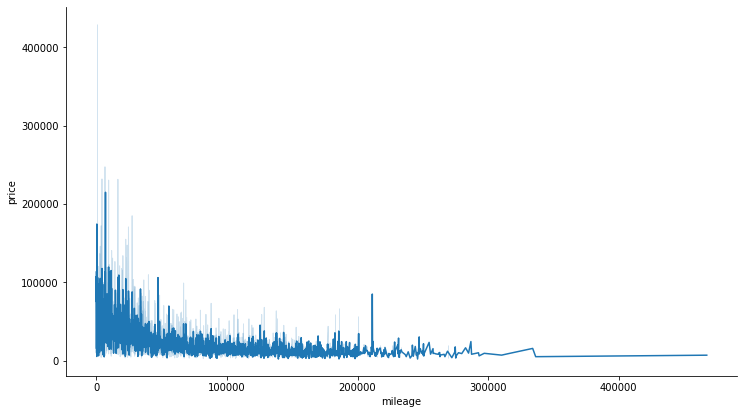

In [32]:
mileage_price_rel = sns.relplot(x="mileage", y="price" ,data=df,kind='line')
mileage_price_rel.fig.set_figwidth(12)
mileage_price_rel.fig.set_figheight(6)

We can cleary see a trend where the price goes down with mileage, but becuse there are so many cars, it looks quite random in the low mileage cars

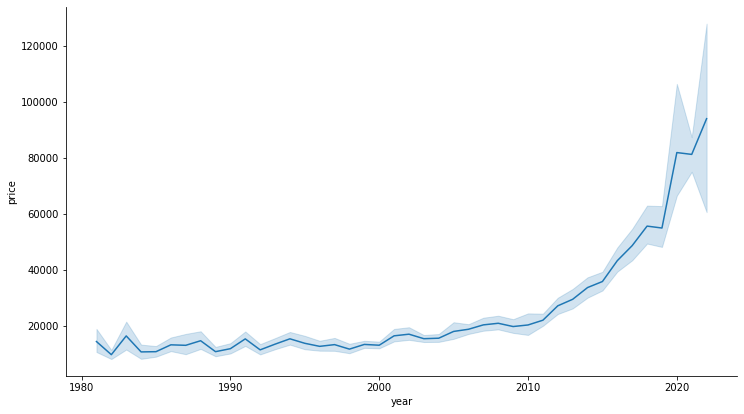

In [33]:
year_price_rel = sns.relplot(x="year", y="price" ,data=df,kind='line')
year_price_rel.fig.set_figwidth(12)
year_price_rel.fig.set_figheight(6)

We can clearly see that newer car are more expensive, but in the newer cars, the price range is bigger

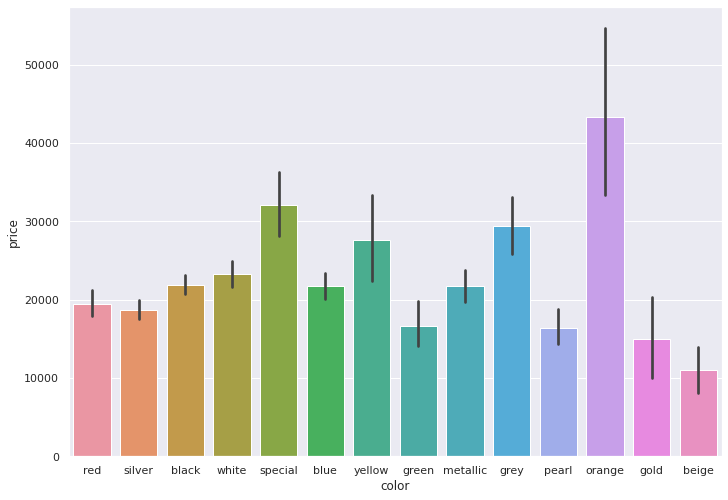

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
color_price_rel = sns.barplot(x="color", y="price" ,data=df)

Orange is the highest priced color, maybe beacuse it not very common color, used mainly by the more premium cars of BMW, Porsche. or maybe becuse thats the cars that have benn sold on this site

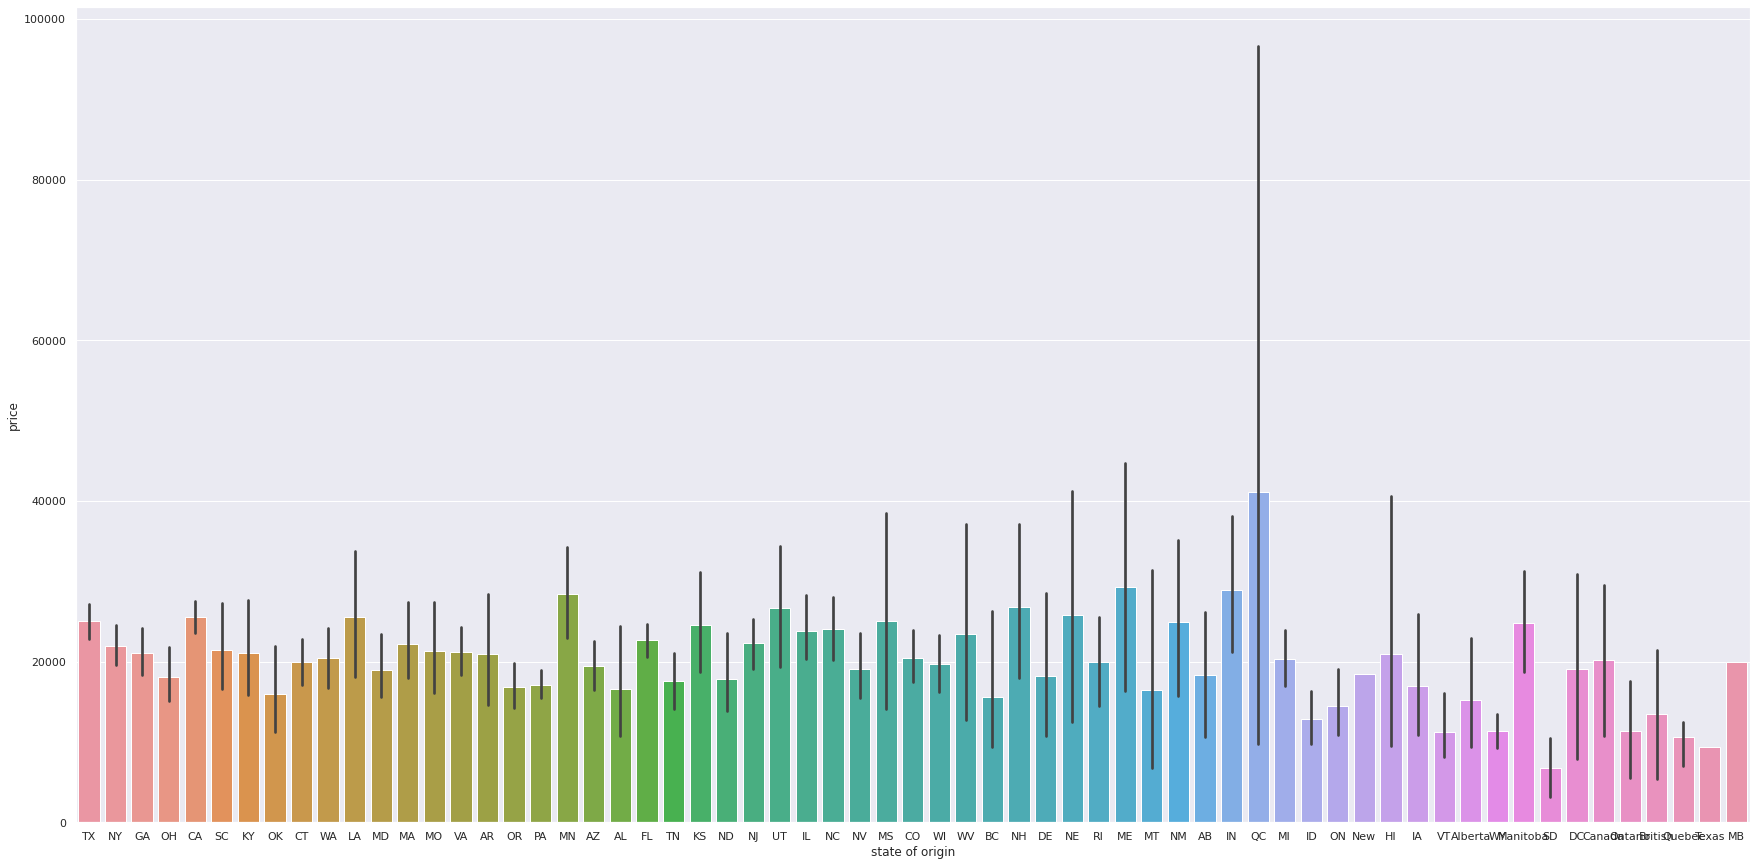

In [35]:
sns.set(rc={'figure.figsize':(30,15)})
body_price_rel = sns.barplot(x="state of origin", y="price" ,data=df)

In [36]:
df[df['price'] >200000]

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,num of bids,num of comments,num of images,price
286,2016,Mercedes-Benz,G63 AMG,6600,FL,5500,V8,4WD/AWD,Automatic,7,SUV/Crossover,black,6,3,65,112,132,247500
447,2005,Ferrari,F430,24600,CA,4300,V8,Rear-wheel drive,Manual,6,Convertible,special,6,6,45,113,95,220000
706,2018,Mercedes-Benz,G550,4300,CA,4000,V8,4WD/AWD,Automatic,7,SUV/Crossover,black,7,4,39,95,173,232000
1104,2008,Porsche,911,16500,QC,3600,Flat-6,Rear-wheel drive,Manual,6,Coupe,green,7,4,29,235,161,231500
1234,2017,Mercedes-Benz,G550,9400,MD,4000,V8,4WD/AWD,Automatic,7,SUV/Crossover,special,5,5,31,123,113,230500
3109,2020,Lamborghini,Aventador,400,CA,6500,V12,4WD/AWD,Automatic,7,Coupe,special,7,3,30,721,97,557000
5754,2018,McLaren,720S,6997,MA,4000,V8,Rear-wheel drive,Automatic,7,Coupe,blue,5,2,33,694,67,215000


In [37]:
#df = df.drop('state of origin', axis =1)

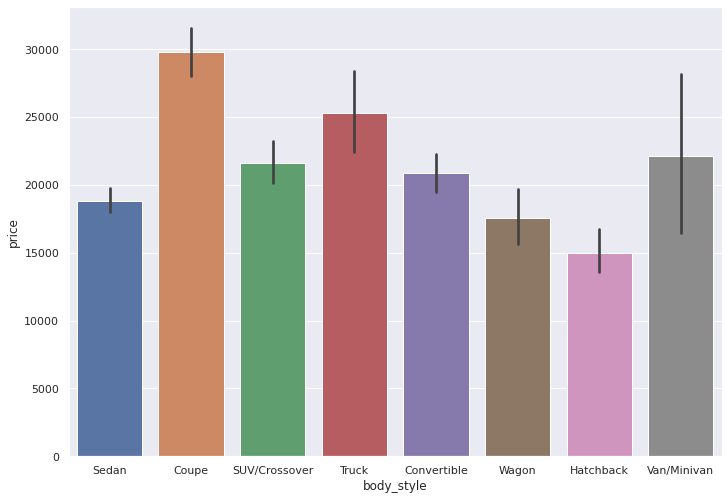

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
body_price_rel = sns.barplot(x="body_style", y="price" ,data=df)

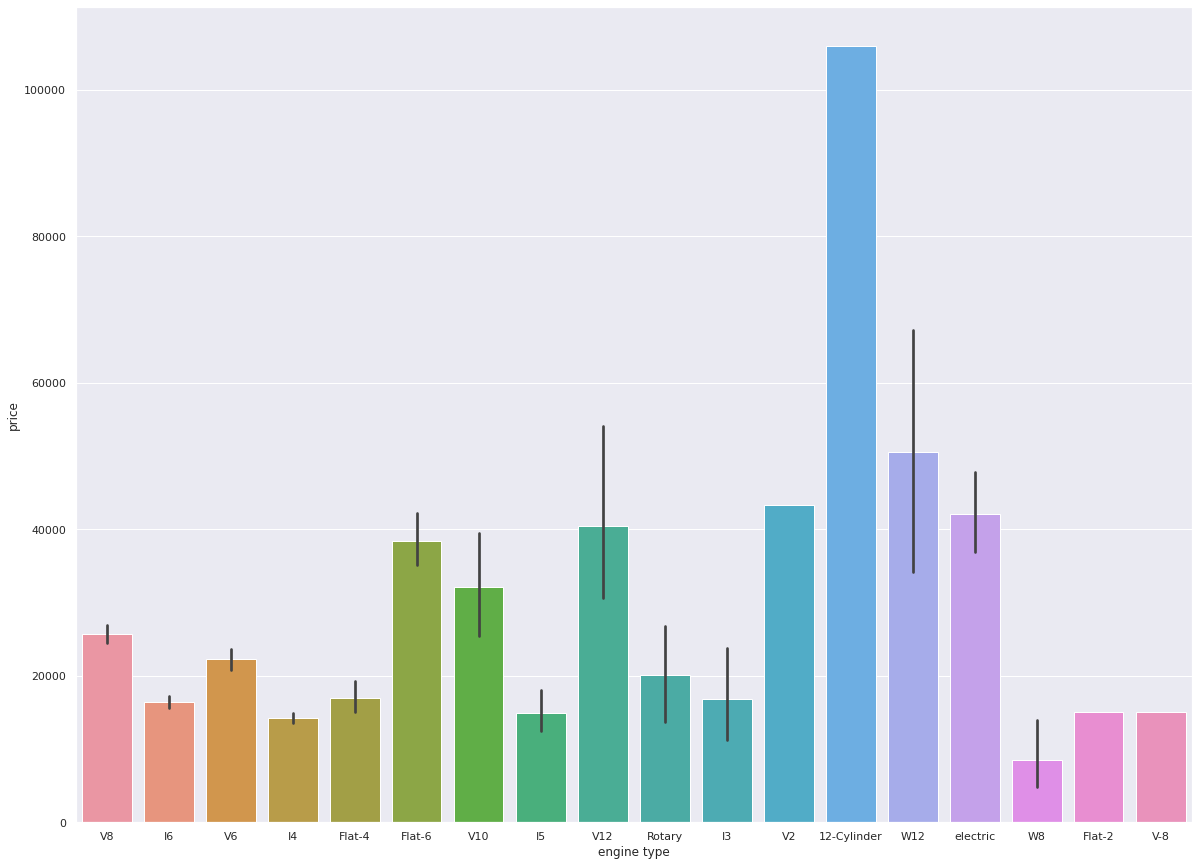

In [39]:
sns.set(rc={'figure.figsize':(20,15)})
body_price_rel = sns.barplot(x="engine type", y="price" ,data=df)

In [40]:
df[df['engine type'] == '12-Cylinder']

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,num of bids,num of comments,num of images,price
525,1987,Ferrari,Testarossa,47200,NJ,4900,12-Cylinder,Rear-wheel drive,Manual,5,Coupe,special,6,6,31,109,134,106000


In [41]:
df['age'] = 2023 - df['year']
df['miles per year'] = df['mileage']/df['age']

In [42]:
df.describe()

,year,mileage,engine size,number of gears,numberg of higlights,number of flaws,num of bids,num of comments,num of images,price,age,miles per year
count,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000
mean,2003.689454,82828.562210,3653.165154,5.487598,5.324662,5.666263,28.708409,68.373059,116.102642,22193.185521,19.310546,4710.873423
std,9.239537,54940.257435,1450.959322,1.276513,0.888873,3.945184,13.227280,51.589174,45.765879,23224.165271,9.239537,3033.859171
min,1981.000000,0.000000,0.000000,-1.000000,3.000000,0.000000,1.000000,2.000000,37.000000,1800.000000,1.000000,0.000000
25%,1997.000000,41600.000000,2500.000000,5.000000,5.000000,3.000000,19.000000,36.000000,83.000000,9000.000000,12.000000,2372.604167
50%,2004.000000,74500.000000,3400.000000,5.000000,5.000000,5.000000,27.000000,55.000000,106.000000,15152.000000,19.000000,4204.000000
75%,2011.000000,113600.000000,4700.000000,6.000000,6.000000,8.000000,37.000000,85.000000,139.000000,25870.000000,26.000000,6577.365729
max,2022.000000,467400.000000,8400.000000,10.000000,9.000000,39.000000,139.000000,979.000000,385.000000,557000.000000,42.000000,25711.111111


In [43]:
df.isna().sum()

year                    0
make                    0
model                   0
mileage                 0
state of origin         0
engine size             0
engine type             0
drivetrain              0
transmmision type       0
number of gears         0
body_style              0
color                   0
numberg of higlights    0
number of flaws         0
num of bids             0
num of comments         0
num of images           0
price                   0
age                     0
miles per year          0
dtype: int64

## Machine learning

first, I divide the catagorial data (make/ model) into binary options

In [44]:
cars_df_with_dummies = pd.get_dummies(df)

In [45]:
cars_df_with_dummies

,year,mileage,engine size,number of gears,numberg of higlights,number of flaws,num of bids,num of comments,num of images,price,...,color_green,color_grey,color_metallic,color_orange,color_pearl,color_red,color_silver,color_special,color_white,color_yellow
1,1992,15100,5700,4,5,0,23,83,90,9300,...,0,0,0,0,0,1,0,0,0,0
2,2001,67800,3200,6,5,10,32,115,82,29000,...,0,0,0,0,0,0,1,0,0,0
4,2002,125800,4600,5,5,15,29,26,146,9600,...,0,0,0,0,0,0,0,0,0,0
6,2007,108500,4400,6,4,0,21,54,77,16000,...,0,0,0,0,0,0,0,0,0,0
8,1995,94700,4000,6,6,12,30,26,152,14000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5759,1998,119756,4600,4,5,3,24,166,41,4500,...,0,0,0,0,0,0,0,0,1,0
5760,1997,167495,4500,4,7,3,64,222,135,19700,...,0,0,0,0,0,0,0,0,0,0
5761,2006,86240,2500,5,6,5,25,110,139,6300,...,0,0,0,0,0,0,0,0,0,0
5763,2007,128885,5200,6,5,9,11,118,126,7900,...,0,0,1,0,0,0,0,0,0,0


I want to make each car make/model more unqiue, to help the knn. so I will multiply those colums by a scaler

In [46]:
featuers = cars_df_with_dummies.columns

for f in featuers:
    if "make" in f or "model" in f:
        cars_df_with_dummies[f] = cars_df_with_dummies[f].apply(lambda x: x*10000)
        cars_df_with_dummies[f] = cars_df_with_dummies[f].astype(str).astype(int)

cars_df_with_dummies.describe()

,year,mileage,engine size,number of gears,numberg of higlights,number of flaws,num of bids,num of comments,num of images,price,...,color_green,color_grey,color_metallic,color_orange,color_pearl,color_red,color_silver,color_special,color_white,color_yellow
count,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,...,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000,4959.000000
mean,2003.689454,82828.562210,3653.165154,5.487598,5.324662,5.666263,28.708409,68.373059,116.102642,22193.185521,...,0.042347,0.032466,0.069570,0.008469,0.021375,0.104457,0.157491,0.078645,0.134906,0.015124
std,9.239537,54940.257435,1450.959322,1.276513,0.888873,3.945184,13.227280,51.589174,45.765879,23224.165271,...,0.201400,0.177253,0.254447,0.091648,0.144646,0.305883,0.364300,0.269211,0.341658,0.122059
min,1981.000000,0.000000,0.000000,-1.000000,3.000000,0.000000,1.000000,2.000000,37.000000,1800.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,41600.000000,2500.000000,5.000000,5.000000,3.000000,19.000000,36.000000,83.000000,9000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2004.000000,74500.000000,3400.000000,5.000000,5.000000,5.000000,27.000000,55.000000,106.000000,15152.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2011.000000,113600.000000,4700.000000,6.000000,6.000000,8.000000,37.000000,85.000000,139.000000,25870.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2022.000000,467400.000000,8400.000000,10.000000,9.000000,39.000000,139.000000,979.000000,385.000000,557000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


scale the data

In [64]:
scaler = StandardScaler()

price_label = cars_df_with_dummies['price']
cars_without_price = cars_df_with_dummies.drop(['price'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(cars_without_price,price_label,test_size=0.2,random_state=42)
X_train,X_validate,y_train,y_validate = train_test_split(X_train,y_train,test_size=0.2,random_state=50)

In [48]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validate = scaler.transform(X_validate)

### Evaluating Model Performance:
in this project I chose to evaluate the model performance with the r2 and mae matric.

Mean Absolute Error (MAE) is the mean of the absolute value of the errors, the lower the better.I chose that one becuase it gives a human readable and easy to understand value. It is calculated with this formula

$$ MAE = \frac{\sum_{i=1}^{N} (x_{i} - \hat{x}_{i})}{N}$$

R2 is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). It is calculated with this formula:
$$ R^{2} = \frac{variance_{mean} - variance_{model}}{variance_{mean}} $$

### Simple models

In [49]:
linear_reg = LinearRegression(normalize = False,positive = False)
linear_reg.fit(X_train, y_train)
initial_prediction = linear_reg.predict(X_validate)

print(f"r2 score: {r2_score(y_validate,initial_prediction)}")
print (f"MAE:{mean_absolute_error(y_validate,initial_prediction)}")

-4.498727133066317e+32
1.02442234804563e+20


In [50]:
knn_reg = KNeighborsRegressor(n_neighbors=100)

knn_reg.fit(X_train, y_train)
initial_prediction = knn_reg.predict(X_validate)

print(f"r2 score: {r2_score(y_validate,initial_prediction)}")
print (f"MAE:{mean_absolute_error(y_validate,initial_prediction)}")

0.21440390485227523
13218.655025188917


The basic models are not very good on this data set, This is becuase the data is not clean and ready for data science usage, but it is actuly a real world data, where there is some people error(like some cars getting a ragne of prices) and some parameters that the model is unable to learn(like the quality of pictures and the text of highlights and flaws)

## More advanced models (aren't in this course scope)

In [51]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
initial_prediction = rf_reg.predict(X_validate)

print(f"r2 score: {r2_score(y_validate,initial_prediction)}")
print (f"MAE:{mean_absolute_error(y_validate,initial_prediction)}")

0.793557029660669
6015.4858690176325


We already see a big jump in the score here, and small quite small MAE, that means this model is able to learn more about the data as it is

In [52]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train, y_train)
initial_prediction = gb_reg.predict(X_validate)

print(f"r2 score: {r2_score(y_validate,initial_prediction)}")
print (f"MAE:{mean_absolute_error(y_validate,initial_prediction)}")

0.7579003844934963
6675.267313435409


We can see that random forest gave us the best result of almost 80% r2 score on the validation data.
Lets see how our models handle the data:

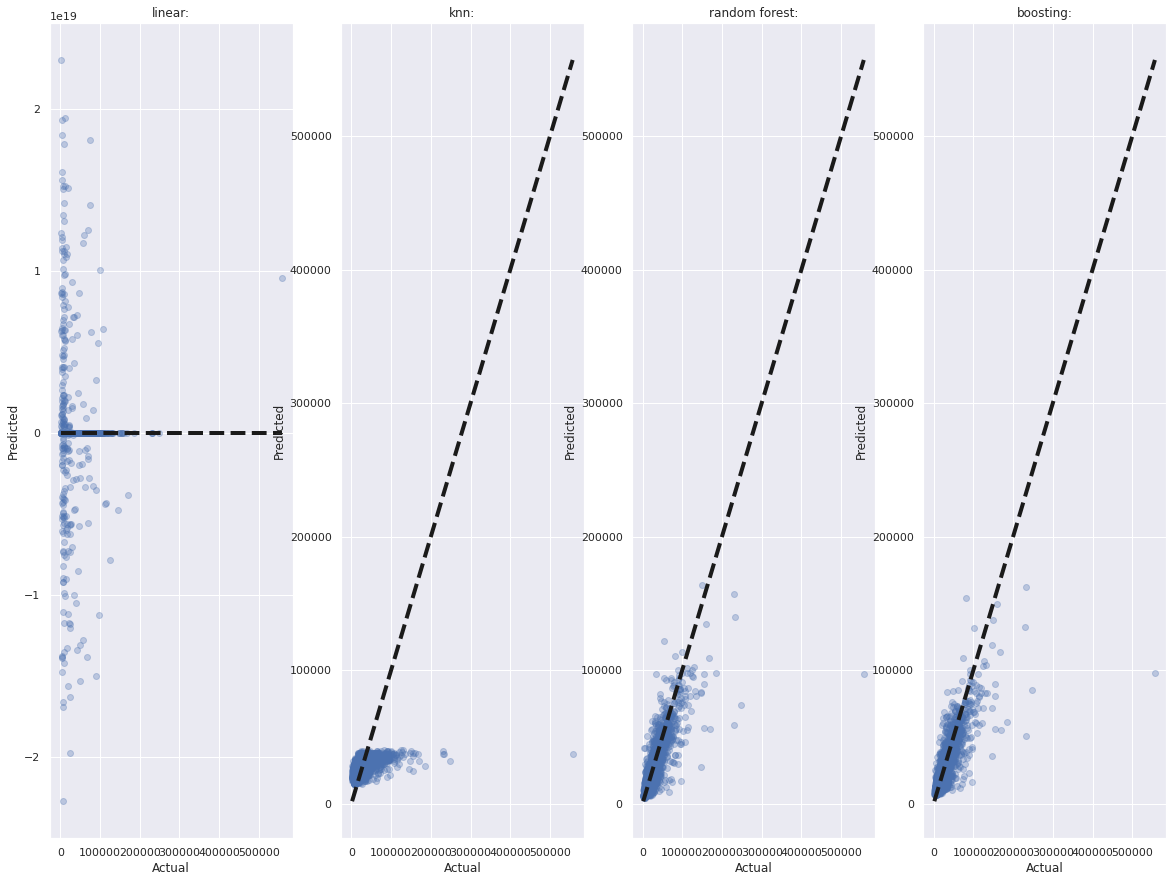

In [53]:
def plot_graps():
    fig, axes = plt.subplots(1,4)
    ((ax1, ax2, ax3,ax4)) = axes

    y_predicted = cross_val_predict(linear_reg, X_train, y_train, cv=10)
    ax1.scatter(y_train, y_predicted, alpha=0.3)
    ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
    ax1.set_xlabel('Actual')
    ax1.set_ylabel('Predicted')
    ax1.set_title('linear:')

    y_predicted = cross_val_predict(knn_reg, X_train, y_train, cv=10)
    ax2.scatter(y_train, y_predicted, alpha=0.3)
    ax2.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.set_title('knn:')

    y_predicted = cross_val_predict(rf_reg, X_train, y_train, cv=10)
    ax3.scatter(y_train, y_predicted, alpha=0.3)
    ax3.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
    ax3.set_xlabel('Actual')
    ax3.set_ylabel('Predicted')
    ax3.set_title('random forest:')

    y_predicted = cross_val_predict(gb_reg, X_train, y_train, cv=10)
    ax4.scatter(y_train, y_predicted, alpha=0.3)
    ax4.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
    ax4.set_xlabel('Actual')
    ax4.set_ylabel('Predicted')
    ax4.set_title('boosting:')

    plt.show()

plot_graps()

We can see that the linear model gives unreal resualts.

knn - gives fine resualt on the lower range of prices, my guess is that it's unable to find some distinct group, being that the data is very noisy

Random forest and Gradiet boosting - very simmilar, The main isusse here is that car the cost > 500K, and it lowers out score.

We can remove the outliers in the train/validation set to get better cross validation results. I chose not to do so, becuse I didn't know how the data would split, and becuse in the real world there our outlies that we need to know about, besides if I handle the outliers now, the model wont scale to larger data

In [54]:
initial_prediction = rf_reg.predict(X_test)

print(r2_score(y_test,initial_prediction))
print (mean_absolute_error(y_test,initial_prediction))

0.7608103650701777
6322.965423387096


### Improving the best model

Becuse we are using t he same random state, it is guaranteed the the split will be the same

In [61]:
X_train,X_test,y_train,y_test = train_test_split(cars_without_price,price_label,test_size=0.2,random_state=42)

In [55]:
params = {
    "min_samples_split": [None,1,2,3,4,5,6,7,8,9,10],
    "min_samples_leaf" : [None,1,2,3,4,5,6,7,8,9,10],
    "min_weight_fraction_leaf": range(0,11),
}

gs = GridSearchCV(rf_reg,params);
gs.fit(X_train,y_train)

0.7574497575734596
6320.336925403226


### Testing the best model

In [ ]:
initial_prediction = gs.predict(X_test)

print(r2_score(y_test,initial_prediction))
print (mean_absolute_error(y_test,initial_prediction))

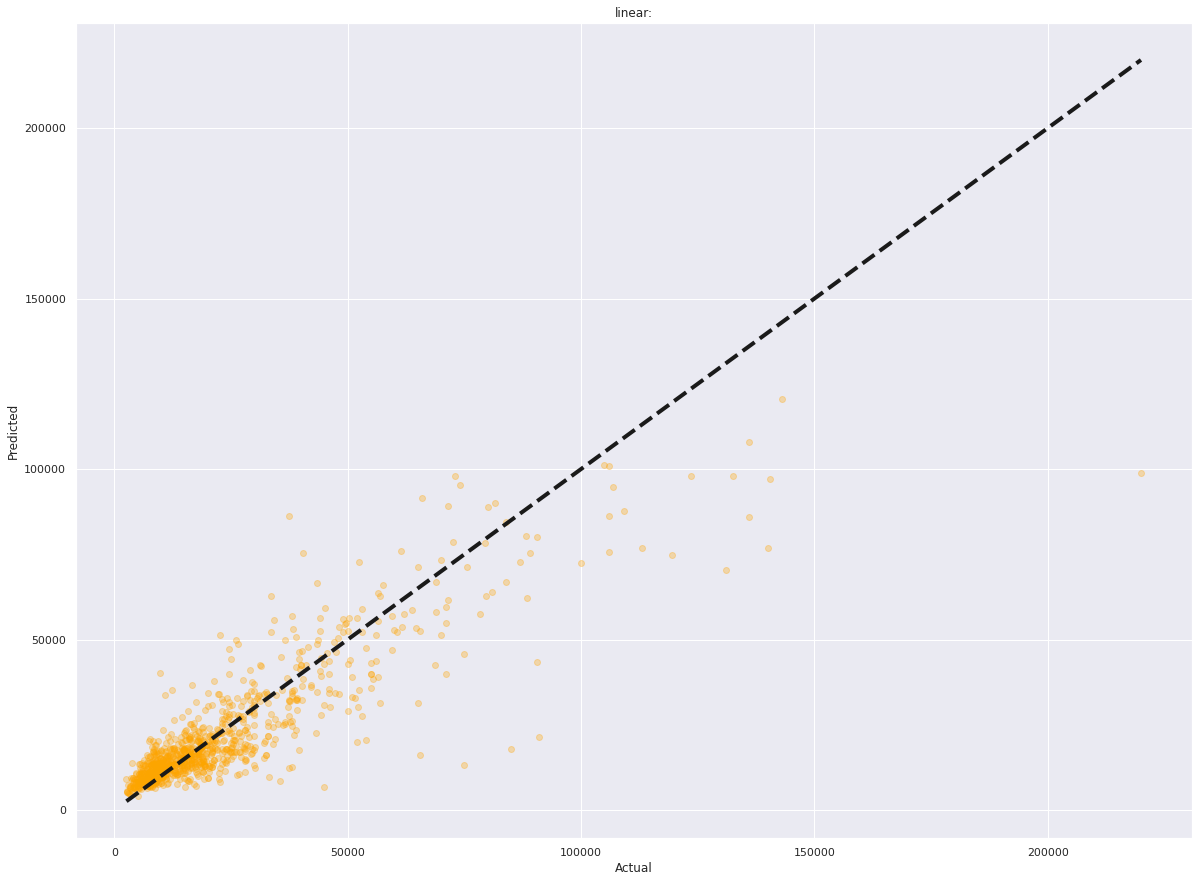

In [56]:
fig, axes = plt.subplots(1,1)
ax = axes

y_predicted = rf_reg.predict(X_test)
ax.scatter(y_test, y_predicted, alpha=0.3, color='orange')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('linear:')

plt.show()

## Conclusion

We can see that our model is doing ok in the lower price range, and not so good at the higher price range. This is expected as the data is not blanced and not consistent.